In [ ]:
#!jupyter nbconvert --to=python MZ_F2R_sensitivity_runs_python3.ipynb

In [1]:
%autosave 5
%matplotlib inline

Autosaving every 5 seconds


# To do
## Include Datasets
isibhv/projects: OCCCI, MareDat"


In [2]:
import pyfesom2 as pf
import math
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
from matplotlib import gridspec

from netCDF4 import Dataset
import time
from datetime import date

import cartopy.crs as ccrs
#import pangaeapy.pandataset as pd

import skill_metrics as sm
from plot_Taylor_normalized import plt_Taylor_norm


In [28]:
# mesh ------------------------------------------------------------------------------------
meshpath = '/work/ollie/mozeisin/mesh/mesh_fesom2.0/core2_meanz'

# list of runs ------------------------------------------------------------------------------------
# first run speciefied is used as control run
resultpath = '/work/ollie/mozeisin/results/f2r1.2'
path_list = '/mo5', '/mo4', '/mo6', '/mo7'
resultpath = [resultpath +i for i in path_list]

# runid of FESOM run
idlist = ('fesom', 'fesom', 'fesom', 'fesom') 

# props of analysis ------------------------------------------------------------------------------------
first_year = 1949
last_year = 1950
years = [first_year, last_year]

depth=0

# props of plotting ------------------------------------------------------------------------------------
mapproj = 'pc'
pc = ccrs.PlateCarree()
rob = ccrs.Robinson()

# label used for plotting
figlabel = ('CTRL (P$_{cm,d}$ = 3.5)', 'CTRL (without mask)', 'P$_{cm,d}$ = 2.5', 'P$_{cm,d}$ = 4.5') 

# rows and columns for subplots
rowscol = (2,2)

# export of analysis ------------------------------------------------------------------------------------
today = date.today().strftime("_%Y_%m_%d")

savepath = '/home/ollie/mozeisin/evaluation/mo_files/F2R_sensitivity/'
htmlname     =  'F2R_sensitivity_' + today +'.html'
htmlpath = '/home/ollie/mozeisin/evaluation/mo_files/html/'

# initialization file specifications -----------------------------------------------------------
ncfileMaredat = "/home/ollie/mozeisin/obs/MarEDat/MarEDat20120716Diatoms.nc"

#obspath      = '/home/ollie/mseifert/py_fesom/CreateRunFiles/Initialization/Output/'

#ncfileAlk                = '/work/ollie/projects/MarESys/evaluation/GLODAPv2.2016b.TAlk.nc'
#ncfileDIC                = '/work/ollie/projects/MarESys/evaluation/GLODAPv2.2016b.TCO2.nc'
#ncfileDSi                = '/work/ollie/projects/MarESys/evaluation/woa13_all_i00_01.nc'
#ncfileDIN                = '/work/ollie/projects/MarESys/evaluation/woa13_all_n00_01.nc'
#ncfileDO2                = '/work/ollie/projects/MarESys/evaluation/woa18_all_o00_01.nc'
#ncfileDFe                = '/work/ollie/projects/MarESys/evaluation/fe_pisces_opa_eq_init_3D.nc' 
#ncfileNPPTotalGlobal     = '/work/ollie/projects/MarESys/evaluation/'+'fesom.initial.mesh.diag.nc'
#ncfileCO2fluxTotalGlobal = '/work/ollie/projects/MarESys/evaluation/'+'fesom.initial.mesh.diag.nc'
#ncfileTemp               = '/work/ollie/projects/MarESys/evaluation/woa18_decav_t00_01.nc'
#ncfileSal                = '/work/ollie/projects/MarESys/evaluation/woa18_decav_s00_01.nc'
#ncfilepCO2               = '/work/ollie/projects/MarESys/evaluation/SOCATv6_tracks_gridded_monthly.nc'
#ncfileMLD                = '/work/ollie/projects/MarESys/evaluation/mld_DR003.nc'
matfileChlsurf           = '/work/ollie/projects/MarESys/evaluation/climatology_annual_chl_1deg_OCCCI_2012_2015.mat'
#txtfileCO2flux           = '/work/ollie/projects/MarESys/evaluation/CO2_flux2015_Takahashietal2009_original.txt'


In [29]:
resultpath

['/work/ollie/mozeisin/results/f2r1.2/mo5',
 '/work/ollie/mozeisin/results/f2r1.2/mo4',
 '/work/ollie/mozeisin/results/f2r1.2/mo6',
 '/work/ollie/mozeisin/results/f2r1.2/mo7']

In [30]:
# mesh initialization -----------------------------------------------------------
mesh = pf.load_mesh(meshpath)

# load FESOM mesh diag -------------------------------------------------------------------------------
meshdiag= meshpath +'fesom.mesh.diag.nc'
#!ncdump -h $meshdiag

diag = pf.get_meshdiag(mesh)
#print(diag)
#print(diag['Z']) # depth of layers
mesh_depths = diag['Z'].values

# plot mesh overview -------------------------------------------------------------------------------
if False: # check mesh setup nodal and area
    runid = 'mo4/fesom'
    meshdiag=resultpath+'/'+runid+'.mesh.diag.nc'
    #!ncdump -h $meshdiag

    diag = pf.get_meshdiag(mesh,meshdiag=meshdiag, runid=runid)
    #print(diag)
    #print(diag['Z']) # depth of layers
    mesh_depths = diag['Z'].values
    print('Mesh layer depths:'), print(mesh_depths)
    
    nod_area = diag.rename_dims({"nl": "nz1", "nod_n": "nod2"}).nod_area
    nod_area.load()
    #print(np.shape(nod_area[:,:]), type(nod_area))
    
if False:    
    # whole globe
    pf.plot(mesh,np.array(nod_area[0,:]),units='Surface nodal area')
    
    # plot nodal area and mesh structure together
    pf.tplot(mesh, np.array(nod_area[0,:]), ptype='tri', box=[-30, 30, 60, 82], mapproj='np',lw=0.5,units='nodal area')
    pf.tplot(mesh, np.array(nod_area[0,:]), ptype='tri', box=[-30, 30, -30, 30], mapproj='merc',lw=0.5,units='nodal area')

In [31]:
def mygrid(m,coast = True):
    g1 = m.gridlines(draw_labels = True)
    g1.xlabels_top = False
    g1.ylabels_right = False
    g1.xlabel_style = {'size': 12, 'color': 'gray'}
    g1.ylabel_style = {'size': 12, 'color': 'gray'}
    
    if(coast == True):
        m.coastlines(resolution='110m', color='black', linewidth=1)
        #m.add_feature(land_poly)


# Load MarEDAt

In [32]:
!ncdump -h $ncfileMaredat

netcdf MarEDat20120716Diatoms {
dimensions:
	LONGITUDE = 360 ;
	LATITUDE = 180 ;
	DEPTH = 33 ;
	TIME = 12 ;
variables:
	float LONGITUDE(LONGITUDE) ;
		LONGITUDE:units = "degrees" ;
	float LATITUDE(LATITUDE) ;
		LATITUDE:units = "degrees" ;
	float DEPTH(DEPTH) ;
		DEPTH:units = "meters" ;
		DEPTH:positive = "down" ;
	float TIME(TIME) ;
		TIME:units = "seconds since 0-01-01" ;
	float OBSERVATIONS(TIME, DEPTH, LATITUDE, LONGITUDE) ;
		OBSERVATIONS:_FillValue = 1.e+35f ;
	float BIOMASS(TIME, DEPTH, LATITUDE, LONGITUDE) ;
		BIOMASS:units = "ug/L" ;
		BIOMASS:_FillValue = 1.e+35f ;
	float MEDIAN_BIOM(TIME, DEPTH, LATITUDE, LONGITUDE) ;
		MEDIAN_BIOM:units = "ug/L" ;
		MEDIAN_BIOM:_FillValue = 1.e+35f ;
	float STDEV_BIOM(TIME, DEPTH, LATITUDE, LONGITUDE) ;
		STDEV_BIOM:_FillValue = 1.e+35f ;
	float NON_ZERO_OBS(TIME, DEPTH, LATITUDE, LONGITUDE) ;
		NON_ZERO_OBS:_FillValue = 1.e+35f ;
	float NON_ZERO_BIOM(TIME, DEPTH, LATITUDE, LONGITUDE) ;
		NON_ZERO_BIOM:units = "ug/L" ;
		NON_ZERO_BIOM:_Fil

In [33]:
f          = Dataset(ncfileMaredat, 'r')
d_biomass  = f['BIOMASS'][:] # mug C/L = mg C /m3
lon_maredat      = f['LONGITUDE'][:]
lat_maredat    = f['LATITUDE'][:]
depth_maredat    = f['DEPTH'][:]

d_biomass[:][d_biomass[:] == 1e+35] = np.nan # remove fill value
print(np.shape(d_biomass))

# mean over year
d_biomass_annual = np.nanmean(d_biomass[:],axis=0)
print(np.shape(d_biomass_annual))

# depth indices
dep_ind1  = np.nonzero((0 <= depth_maredat[:] )&(depth_maredat[:] <= 5))
dep_ind2  = np.nonzero((5 < depth_maredat[:] )&(depth_maredat[:] <= 25))
dep_ind3  = np.nonzero((25 < depth_maredat[:] )&(depth_maredat[:] <= 100))
dep_ind4  = np.nonzero((100 < depth_maredat[:]))

# mean over depth ranges,
# fill masked array to normal array
d_biomass_tot = np.squeeze(np.nanmean(d_biomass_annual, axis=0))
d_biomass_0_5 = np.squeeze(np.nanmean(d_biomass_annual[dep_ind1], axis=0))
d_biomass_5_25 = np.squeeze(np.nanmean(d_biomass_annual[dep_ind2], axis=0))
d_biomass_25_100 = np.squeeze(np.nanmean(d_biomass_annual[dep_ind3], axis=0))
d_biomass_100_bot = np.squeeze(np.nanmean(d_biomass_annual[dep_ind4], axis=0))

if False: # if you use this, first remove np.nanmean from all lines!
    # fill masked array to normal array
    d_biomass_tot = np.ma.filled(np.squeeze(np.nanmean(d_biomass_annual, axis=0)),0)
    d_biomass_0_5 = np.ma.filled(np.squeeze(np.nanmean(d_biomass_annual[dep_ind1], axis=0)),0)
    d_biomass_5_25 = np.ma.filled(np.squeeze(np.nanmean(d_biomass_annual[dep_ind2], axis=0)),0)
    d_biomass_25_100 = np.ma.filled(np.squeeze(np.nanmean(d_biomass_annual[dep_ind3], axis=0)),0)
    d_biomass_100_bot = np.ma.filled(np.squeeze(np.nanmean(d_biomass_annual[dep_ind4], axis=0)),0)

print(np.shape(d_biomass_tot))
print(np.shape(d_biomass_0_5))

(12, 33, 180, 360)
(33, 180, 360)
(180, 360)
(180, 360)


In [34]:
np.nanmean(d_biomass_0_5), np.nanmin(d_biomass_0_5), np.nanmax(d_biomass_0_5)

(27.388897, 0.0024, 4154.661)

<ipython-input-35-987f460f8b29>:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/home/ollie/mozeisin/.conda/envs/pyfesom2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/ollie/mozeisin/.conda/envs/pyfesom2/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ollie/mozeisin/.conda/envs/pyfesom2/lib/python3.8/site-packages/cartopy/mpl/gr

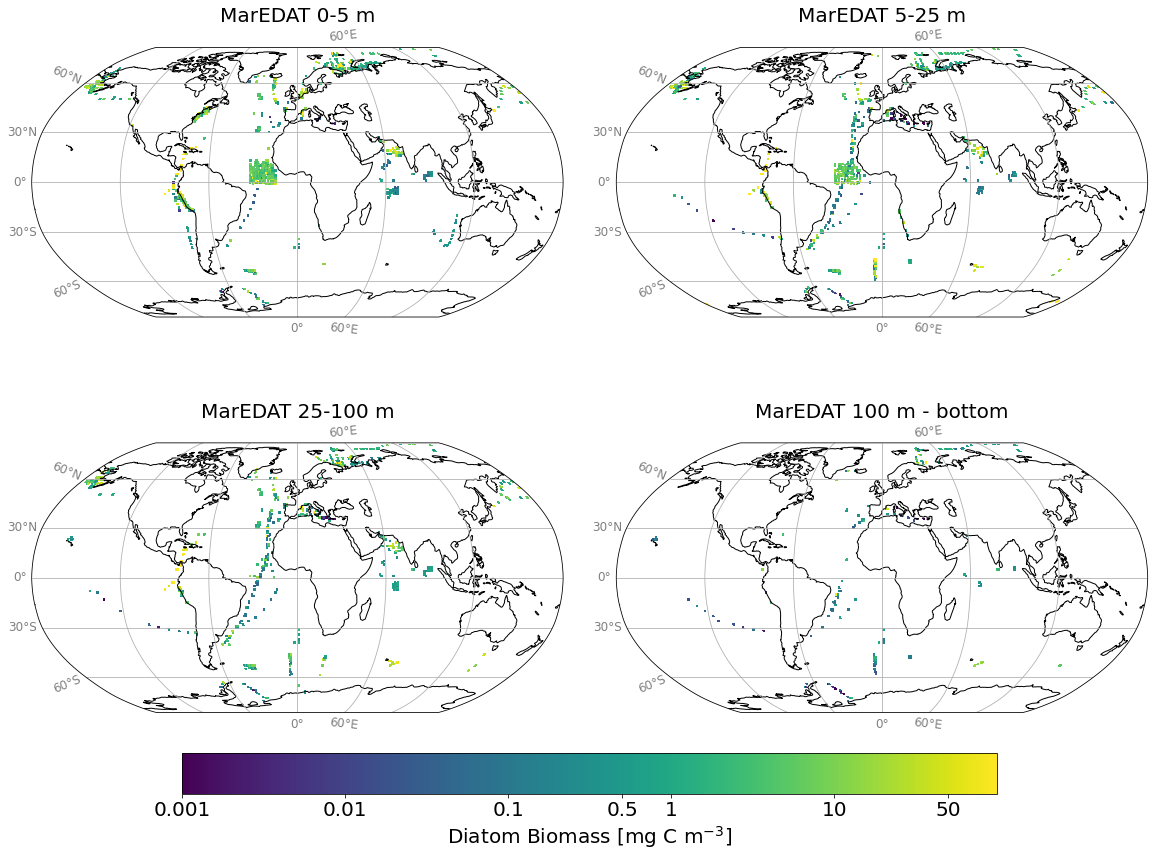

In [35]:
fig, axes = plt.subplots(2,2, 
                         subplot_kw=dict(projection=ccrs.Robinson()),
                         gridspec_kw={'hspace': 0.001, 'wspace': 0.1},
                         figsize=(20,15))
fig.tight_layout()

# 0-5 m
m1 = axes[0,0]
f1 = m1.pcolormesh(lon_maredat, lat_maredat, np.log10(d_biomass_0_5), 
                   transform = ccrs.PlateCarree(),
                    shading='flat', vmin=np.log10(0.001), vmax=np.log10(100), 
                    cmap=plt.cm.viridis)
mygrid(m1)
m1.set_title('MarEDAT 0-5 m', fontsize=20)


# 5-25 m
m2 = axes[0,1]
f2 = m2.pcolormesh(lon_maredat, lat_maredat, np.log10(d_biomass_5_25), 
                   transform = ccrs.PlateCarree(),
                    shading='flat', vmin=np.log10(0.001), vmax=np.log10(100), 
                    cmap=plt.cm.viridis)
mygrid(m2)
m2.set_title('MarEDAT 5-25 m', fontsize=20)

# 25-100 m
m3 = axes[1,0]
f3 = m3.pcolormesh(lon_maredat, lat_maredat, np.log10(d_biomass_25_100), 
                   transform = ccrs.PlateCarree(),
                    shading='flat', vmin=np.log10(0.001), vmax=np.log10(100), 
                    cmap=plt.cm.viridis)
mygrid(m3)
m3.set_title('MarEDAT 25-100 m', fontsize=20)

# 100-bottom m
m4 = axes[1,1]
f4 = m4.pcolormesh(lon_maredat, lat_maredat, np.log10(d_biomass_100_bot), 
                   transform = ccrs.PlateCarree(),
                    shading='flat', vmin=np.log10(0.001), vmax=np.log10(100), 
                    cmap=plt.cm.viridis)
mygrid(m4)
m4.set_title('MarEDAT 100 m - bottom', fontsize=20)

# add one colorbar for all plots below figure
cbar = fig.colorbar(f1,
                    ax = axes[1,:2], 
                    location ='bottom',
                    ticks=[np.log10(0.001),np.log10(0.01), np.log10(0.1),np.log10(0.5), np.log10(1),np.log10(10),np.log10(50)],
                    fraction=0.1, pad=0.1) 
cbar.ax.set_xticklabels(['0.001','0.01','0.1','0.5','1','10','50'], fontsize=20) 
cbar.set_label('Diatom Biomass [mg C m$^{-3}$]', fontsize=20)
#cbar.set_label('Log$_{10}$ Biomass [$\mu$g L $^{-1}$]', fontsize=20)



# Diatom carbon

In [36]:
#NCfesom = resultpath[0] + '/DiaC.'+idlist[0]+'.1948.nc' # DiaC:units = "[mmol/m3]"
#!ncdump -h $NCfesom

units = 'Diatom intracell. Carbon [mg C m$^{{-3}}$]\n{0}-{1} at {2} m'.format(years[0],years[1],depth)
#units = 'Intracellular C [mg C m$^{-3}$]'

DiaC = [0]*len(idlist)

for i in range(len(idlist)):
    print(resultpath[i])
    DiaC[i] = pf.get_data(resultpath[i], "DiaC", years, mesh, runid=idlist[i], how="mean", compute=True, depth=depth)
    DiaC[i] = DiaC[i] * 12.01

/work/ollie/mozeisin/results/f2r1.2/mo5
Model depth: 0.0
/work/ollie/mozeisin/results/f2r1.2/mo4
Model depth: 0.0
/work/ollie/mozeisin/results/f2r1.2/mo6
Model depth: 0.0
/work/ollie/mozeisin/results/f2r1.2/mo7
Model depth: 0.0


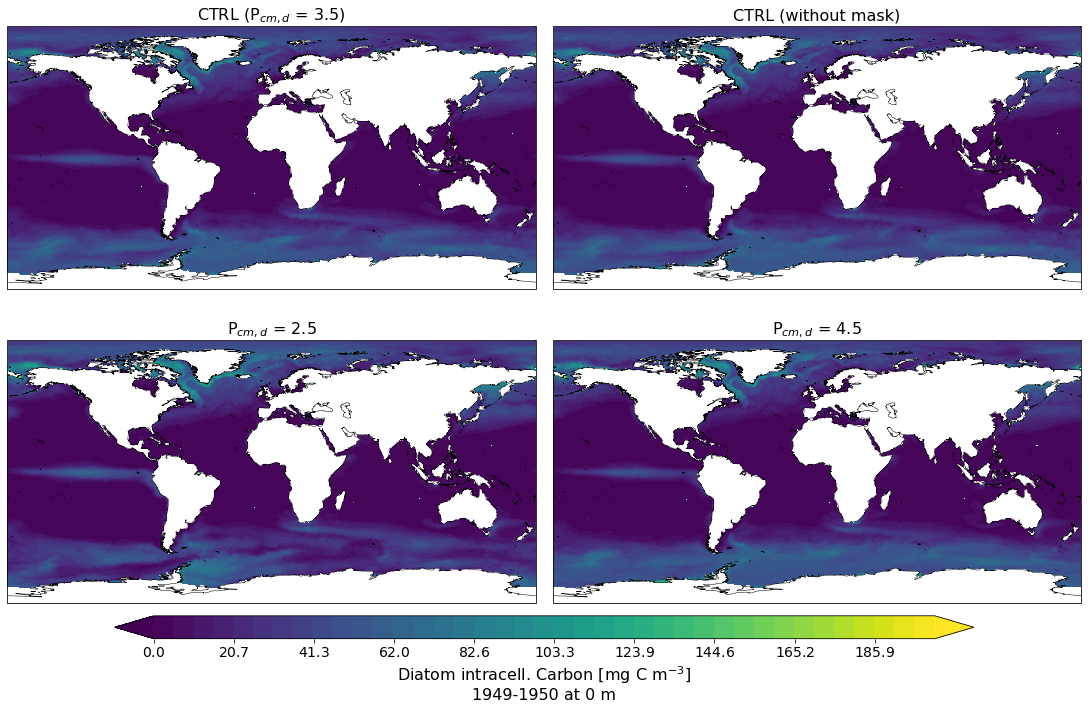

In [37]:
fig = pf.plot(mesh, [data for data in DiaC], mapproj = mapproj, units=units, cmap = 'viridis',
              rowscol = rowscol, #(math.ceil(len(idlist)/3), 3), 
              figsize = (15,10),
              titles=[title for title in figlabel])

In [ ]:
## differences
fig = pf.plot(mesh, [data-DiaC[0] for data in DiaC], mapproj = mapproj, units='MODEL - CTRL\n'+units, 
              rowscol = rowscol, #(math.ceil(len(idlist)/3), 3), 
              figsize = (15,10),
              #levels = (-2.5e-2,2.5e-2, 30), 
              cmap = 'RdBu',
              titles=[title for title in figlabel])

# FESOM comparison to MarEDat

In [38]:
if False:
    print(np.shape(mesh.zlev)) # levels
    print(np.shape(mesh_depths)) # layers

    print(mesh.zlev)
    print(mesh_depths)

In [39]:
def f2maredat_levels(resultpath, runid):
    # get interpolation input -> data of all levels
    # annual mean of fesom data already caluclated when reading model results
    print('\nProcessing {0} for years {1}-{2}'.format(resultpath,years[0],years[1]))
    
    DiaC_interp_in = pf.get_data(resultpath, "DiaC", years, mesh, runid=runid, how="mean")
    DiaC_interp_in = DiaC_interp_in * 12.01
    #print(np.shape(DiaC_interp_in))

    # interp preperation
    lons, lats = np.meshgrid(lon_maredat, lat_maredat)

    # depth indices similar to MarEDAT
    depth_range = [0,5,25,100,1e5]
    dep_ind1  = np.nonzero((0 >= mesh_depths )&(mesh_depths >= -5))
    dep_ind2  = np.nonzero((-5 > mesh_depths )&(mesh_depths >= -25))
    dep_ind3  = np.nonzero((-25 > mesh_depths )&(mesh_depths >= -100))
    dep_ind4  = np.nonzero((-100 > mesh_depths))

    dep_ind = [dep_ind1,dep_ind2,dep_ind3,dep_ind4]

    # storage
    DiaC_interp_all = [0]*len(dep_ind)

    for d in range(len(dep_ind)):
        d1 = depth_range[d]
        d2 = depth_range[d+1]
        dep_i = dep_ind[d]
        print('\nDepth range {0}-{1} m'.format(d1,d2))
        #print('chose indices:'), print(dep_i)

        DiaC_interp_dep = np.squeeze(DiaC_interp_in[:,dep_i], axis=1)
        DiaC_interp_dep = np.nanmean(DiaC_interp_dep,axis=1)
        #print(np.shape(DiaC_interp_dep))

        # interpolate fesom data to 1x1 grid
        DiaC_interp = pf.fesom2regular(
                data = DiaC_interp_dep,
                mesh = mesh,
                lons = lons, 
                lats = lats)

        #print(np.shape(DiaC_interp))
        print('with mean {0:6.4f} min {1:8.6f} max {2:6.4f}'.format(np.nanmean(DiaC_interp), np.nanmin(DiaC_interp), np.nanmax(DiaC_interp)))

        # save to storage
        DiaC_interp_all[d] = DiaC_interp
        
    return DiaC_interp_all

In [40]:
mo5 = f2maredat_levels(resultpath[0], idlist[0])
mo4 = f2maredat_levels(resultpath[1], idlist[1])
mo6 = f2maredat_levels(resultpath[2], idlist[2])
mo7 = f2maredat_levels(resultpath[3], idlist[3])


Processing /work/ollie/mozeisin/results/f2r1.2/mo5 for years 1949-1950
Depth is None, 3d field will be returned

Depth range 0-5 m
with mean 19.0098 min 0.000677 max 174.2388

Depth range 5-25 m
with mean 17.0840 min 0.000652 max 127.8344

Depth range 25-100 m
with mean 11.1139 min 0.000000 max 39.8261

Depth range 100-100000.0 m
with mean 0.6073 min 0.000000 max 5.8167

Processing /work/ollie/mozeisin/results/f2r1.2/mo4 for years 1949-1950
Depth is None, 3d field will be returned

Depth range 0-5 m
with mean 19.0177 min 0.000677 max 176.5632

Depth range 5-25 m
with mean 17.0886 min 0.000652 max 127.8153

Depth range 25-100 m
with mean 11.1031 min 0.000000 max 41.2252

Depth range 100-100000.0 m
with mean 0.6062 min 0.000000 max 5.8455

Processing /work/ollie/mozeisin/results/f2r1.2/mo6 for years 1949-1950
Depth is None, 3d field will be returned

Depth range 0-5 m
with mean 13.7289 min 0.000208 max 118.3813

Depth range 5-25 m
with mean 12.1582 min 0.000208 max 76.5806

Depth range 

In [41]:
### plot FESOM overview
def plot_FESOM_depths(model, label, savefig=False):
    fig, axes = plt.subplots(2,2, 
                             subplot_kw=dict(projection=ccrs.Robinson()),
                             gridspec_kw={'hspace': 0.001, 'wspace': 0.1},
                             figsize=(20,15))
    fig.tight_layout()

    # 0-5 m
    m1 = axes[0,0]
    f1 = m1.pcolormesh(lon_maredat, lat_maredat, np.log10(model[0]), 
                       transform = ccrs.PlateCarree(),
                        shading='flat', vmin=np.log10(0.001), vmax=np.log10(200), 
                        cmap=plt.cm.viridis)
    mygrid(m1)
    m1.set_title('FESOM 0-5 m', fontsize=20)


    # 5-25 m
    m2 = axes[0,1]
    f2 = m2.pcolormesh(lon_maredat, lat_maredat, np.log10(model[1]), 
                       transform = ccrs.PlateCarree(),
                        shading='flat', vmin=np.log10(0.001), vmax=np.log10(200), 
                        cmap=plt.cm.viridis)
    mygrid(m2)
    m2.set_title('FESOM 5-25 m', fontsize=20)

    # 25-100 m
    m3 = axes[1,0]
    f3 = m3.pcolormesh(lon_maredat, lat_maredat, np.log10(model[2]), 
                       transform = ccrs.PlateCarree(),
                        shading='flat', vmin=np.log10(0.001), vmax=np.log10(200), 
                        cmap=plt.cm.viridis)
    mygrid(m3)
    m3.set_title('FESOM 25-100 m', fontsize=20)

    # 100-bottom m
    m4 = axes[1,1]
    f4 = m4.pcolormesh(lon_maredat, lat_maredat, np.log10(model[3]), 
                       transform = ccrs.PlateCarree(),
                        shading='flat', vmin=np.log10(0.001), vmax=np.log10(200), 
                        cmap=plt.cm.viridis)
    mygrid(m4)
    m4.set_title('FESOM 100 m - bottom', fontsize=20)

    # add one colorbar for all plots below figure
    cbar = fig.colorbar(f1,
                        ax = axes[1,:2], 
                        location ='bottom',
                        ticks=[np.log10(0.001),np.log10(0.01), np.log10(0.1),np.log10(0.5), np.log10(1),np.log10(10),np.log10(50),np.log10(100),np.log10(200)],
                        fraction=0.1, pad=0.1) 
    cbar.ax.set_xticklabels(['0.001','0.01','0.1','0.5','1','10','50','100','200'], fontsize=20) 
    cbar.set_label('Run "'+label+'", Diatom Biomass [mg C m$^{-3}$]', fontsize=20)
    #cbar.set_label('Log$_{10}$ Biomass [$\mu$g L $^{-1}$]', fontsize=20)

    if(savefig == True):
        fig.savefig(savepath+'FESOM_depths_asMarEDat_'+label+'_'+str(years[0])+'to'+str(years[1])+'.png', 
                        dpi = 300, bbox_inches='tight')
    plt.show()

<ipython-input-41-24ddeaefa58e>:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/home/ollie/mozeisin/.conda/envs/pyfesom2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/ollie/mozeisin/.conda/envs/pyfesom2/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ollie/mozeisin/.conda/envs/pyfesom2/lib/python3.8/site-packages/cartopy/mpl/gr

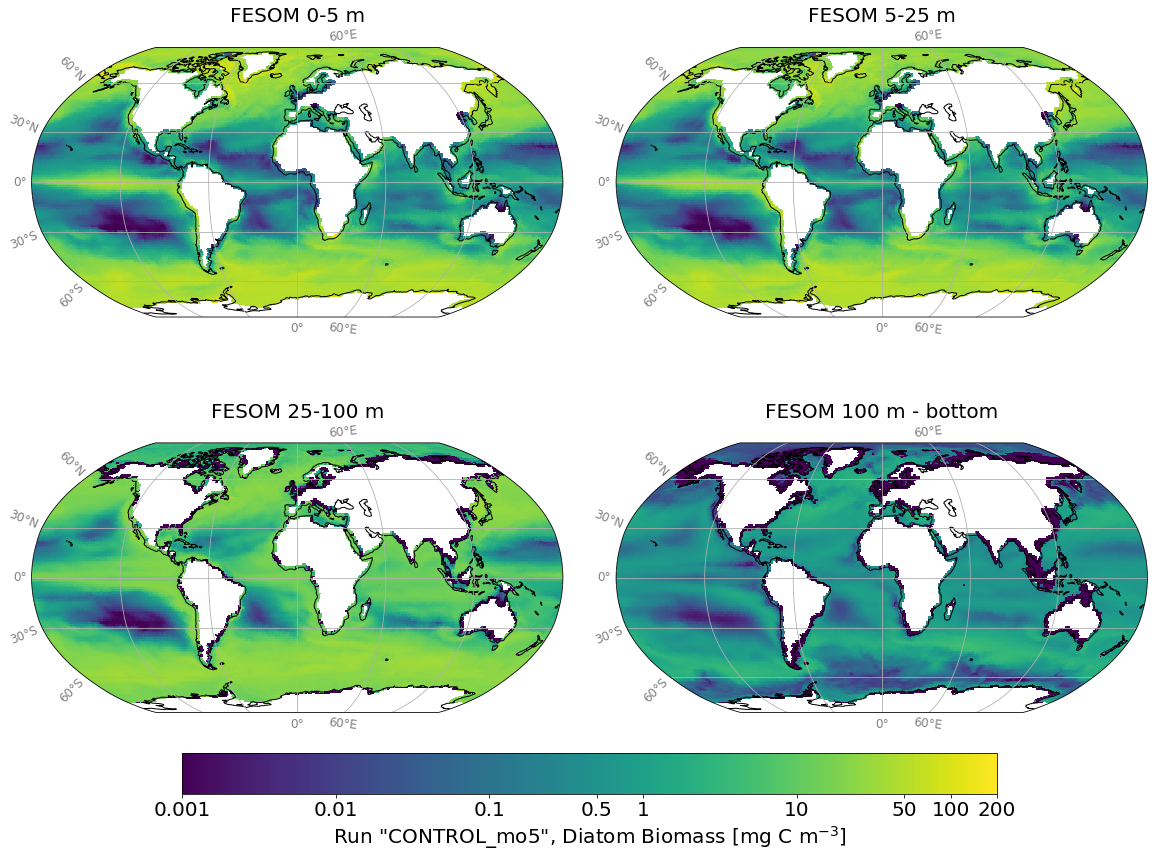

In [42]:
plot_FESOM_depths(mo5,'CONTROL_mo5',True)

In [ ]:
plot_FESOM_depths(mo4,'CONTROL__woMask_mo4',True)

In [ ]:
plot_FESOM_depths(mo6,'mo6_Pcm_25', True)

In [ ]:
plot_FESOM_depths(mo7,'mo7_Pcm_45', True)

# MarEDAT and FESOM side by side

In [43]:
def plot_2cols(model,label,savefig=False):
    '''Plot MarEDAT and FESOM data side by side in two columns, seperated by depth ranges'''
    fig, axes = plt.subplots(4,2, 
                             subplot_kw=dict(projection=ccrs.Robinson()),
                             gridspec_kw={'hspace': 0.001, 'wspace': 0.1},
                             figsize=(30,45))
    fig.tight_layout()

    # 0-5 m maredat ---------------------------------------------------------------------------------------------
    m1 = axes[0,0]
    f1 = m1.pcolormesh(lon_maredat, lat_maredat, np.log10(d_biomass_0_5), 
                       transform = ccrs.PlateCarree(),
                        shading='flat', vmin=np.log10(0.001), vmax=np.log10(200), 
                        cmap=plt.cm.viridis)
    mygrid(m1)
    m1.set_title('MarEDAT 0-5 m', fontsize=20)

    # 0-5 m FESOM
    m1 = axes[0,1]
    f1 = m1.pcolormesh(lon_maredat, lat_maredat, np.log10(model[0]), 
                       transform = ccrs.PlateCarree(),
                        shading='flat', vmin=np.log10(0.001), vmax=np.log10(200), 
                        cmap=plt.cm.viridis)
    mygrid(m1)
    m1.set_title('FESOM 0-5 m', fontsize=20)

    # 5-25 m maredat ---------------------------------------------------------------------------------------------
    m2 = axes[1,0]
    f2 = m2.pcolormesh(lon_maredat, lat_maredat, np.log10(d_biomass_5_25), 
                       transform = ccrs.PlateCarree(),
                        shading='flat', vmin=np.log10(0.001), vmax=np.log10(200), 
                        cmap=plt.cm.viridis)
    mygrid(m2)
    m2.set_title('MarEDAT 5-25 m', fontsize=20)

    # 5-25 m FESOM
    m2 = axes[1,1]
    f2 = m2.pcolormesh(lon_maredat, lat_maredat, np.log10(model[1]), 
                       transform = ccrs.PlateCarree(),
                        shading='flat', vmin=np.log10(0.001), vmax=np.log10(200), 
                        cmap=plt.cm.viridis)
    mygrid(m2)
    m2.set_title('FESOM 5-25 m', fontsize=20)

    # 25-100 m maredat ---------------------------------------------------------------------------------------------
    m3 = axes[2,0]
    f3 = m3.pcolormesh(lon_maredat, lat_maredat, np.log10(d_biomass_25_100), 
                       transform = ccrs.PlateCarree(),
                        shading='flat', vmin=np.log10(0.001), vmax=np.log10(200), 
                        cmap=plt.cm.viridis)
    mygrid(m3)
    m3.set_title('MarEDAT 25-100 m', fontsize=20)

    # 25-100 m FESOM
    m3 = axes[2,1]
    f3 = m3.pcolormesh(lon_maredat, lat_maredat, np.log10(model[2]), 
                       transform = ccrs.PlateCarree(),
                        shading='flat', vmin=np.log10(0.001), vmax=np.log10(200), 
                        cmap=plt.cm.viridis)
    mygrid(m3)
    m3.set_title('FESOM 25-100 m', fontsize=20)

    # 100-bottom m maredat ---------------------------------------------------------------------------------------------
    m4 = axes[3,0]
    f4 = m4.pcolormesh(lon_maredat, lat_maredat, np.log10(d_biomass_100_bot), 
                       transform = ccrs.PlateCarree(),
                        shading='flat', vmin=np.log10(0.001), vmax=np.log10(200), 
                        cmap=plt.cm.viridis)
    mygrid(m4)
    m4.set_title('MarEDAT 100 m - bottom', fontsize=20)

    # 100-bottom m
    m4 = axes[3,1]
    f4 = m4.pcolormesh(lon_maredat, lat_maredat, np.log10(model[3]), 
                       transform = ccrs.PlateCarree(),
                        shading='flat', vmin=np.log10(0.001), vmax=np.log10(200), 
                        cmap=plt.cm.viridis)
    mygrid(m4)
    m4.set_title('FESOM 100 m - bottom', fontsize=20)

    # ---------------------------------------------------------------------------------------------
    # add one colorbar for all plots below figure
    cbar = fig.colorbar(f1,
                        ax = axes[3,:2], 
                        location ='bottom',
                        ticks=[np.log10(0.001),np.log10(0.01), np.log10(0.1),np.log10(0.5), np.log10(1),np.log10(10),np.log10(50),np.log10(100)],
                        fraction=0.1, pad=0.1) 
    cbar.ax.set_xticklabels(['0.001','0.01','0.1','0.5','1','10','50','100'], fontsize=20) 
    cbar.set_label('Diatom Biomass [mg C m$^{-3}$]', fontsize=20)
    #cbar.set_label('Log$_{10}$ Biomass [$\mu$g L $^{-1}$]', fontsize=20)

    if(savefig == True):
        fig.savefig(savepath+'MarEDAT_FESOM_depths_'+label+'_'+str(years[0])+'to'+str(years[1])+'.png', 
                        dpi = 300, bbox_inches='tight')
    plt.show()

<ipython-input-43-9620094b570b>:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
<ipython-input-43-9620094b570b>:65: RuntimeWarning: divide by zero encountered in log10
  f4 = m4.pcolormesh(lon_maredat, lat_maredat, np.log10(d_biomass_100_bot),


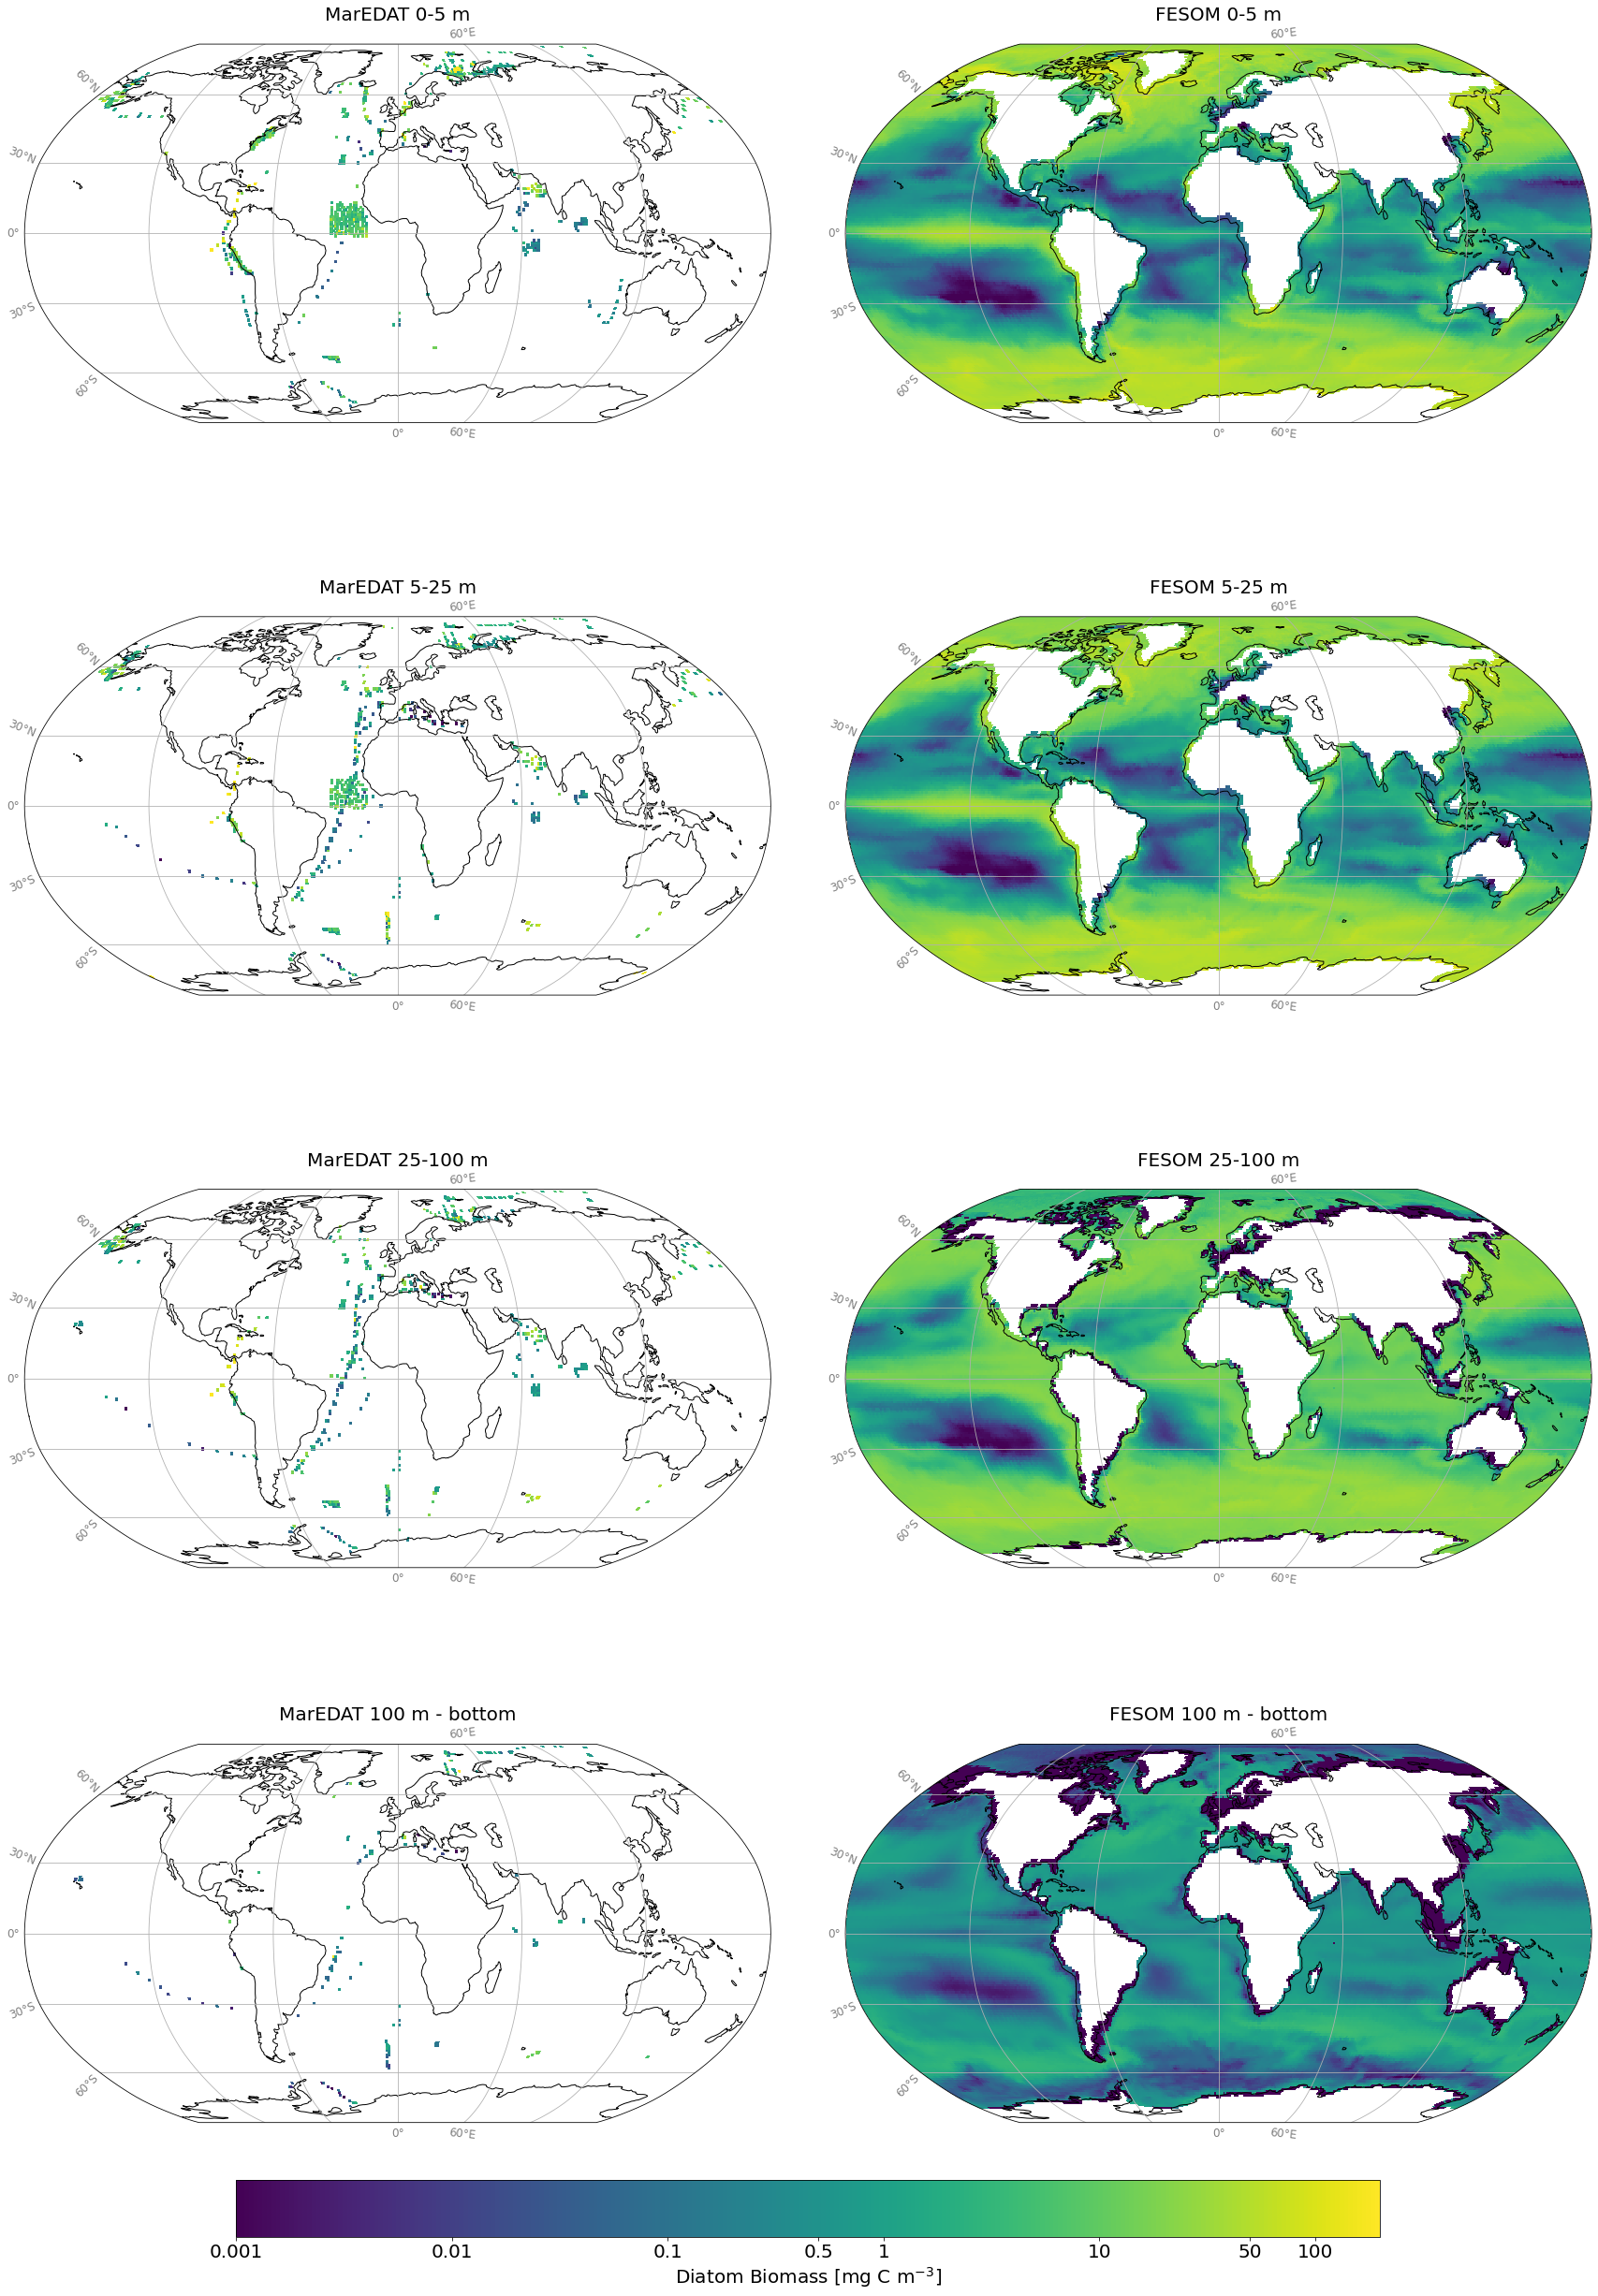

In [44]:
plot_2cols(mo5,'CONTROL_mo5',True)

In [ ]:
plot_2cols(mo4,'CONTROL_woMask_mo4',True)

In [ ]:
plot_2cols(mo6,'mo6_Pcm_25',True)

In [ ]:
plot_2cols(mo7,'mo7_Pcm_45',True)

### apply mask

/home/ollie/mozeisin/.conda/envs/pyfesom2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/ollie/mozeisin/.conda/envs/pyfesom2/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ollie/mozeisin/.conda/envs/pyfesom2/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attri

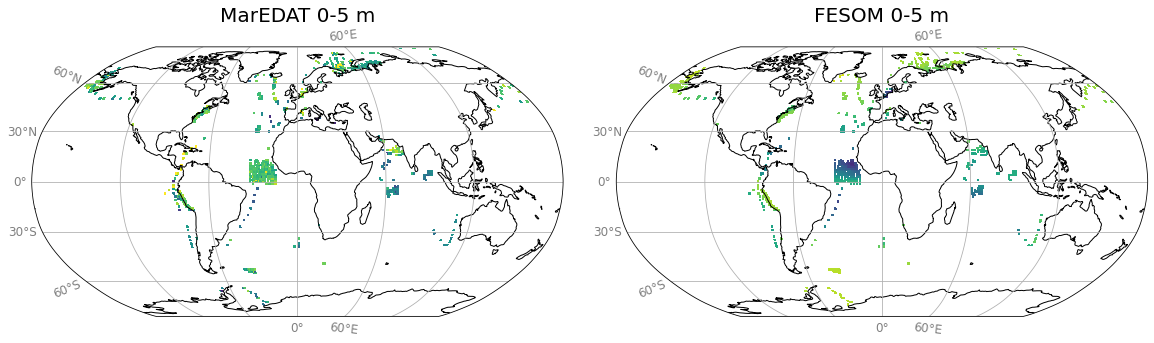

In [15]:
# mask model where MarEDAT not available
if False: # first manual masking
    mo5_ma = [0]*4
    mo5_ma[0] = np.ma.where(np.isnan(d_biomass_0_5),np.nan, mo5[0])
    mo5_ma[1] = np.ma.where(np.isnan(d_biomass_5_25),np.nan, mo5[1])
    mo5_ma[2] = np.ma.where(np.isnan(d_biomass_25_100),np.nan, mo5[2])
    mo5_ma[3] = np.ma.where(np.isnan(d_biomass_100_bot),np.nan, mo5[3])

def mask_model_with_maredat(model):
    '''Mask model data where no MarEDAT available, then fill masked_array for better processing'''
    model_ma = [0]*4
    model_ma[0] = np.ma.filled(np.ma.where(np.isnan(d_biomass_0_5),np.nan, model[0]), fill_value=0)
    #model_ma[0] = np.ma.where(np.isnan(d_biomass_0_5),np.nan, model[0])

    model_ma[1] = np.ma.filled(np.ma.where(np.isnan(d_biomass_5_25),np.nan, model[1]), fill_value=0)
    model_ma[2] = np.ma.filled(np.ma.where(np.isnan(d_biomass_25_100),np.nan, model[2]), fill_value=0)
    model_ma[3] = np.ma.filled(np.ma.where(np.isnan(d_biomass_100_bot),np.nan, model[3]), fill_value=0)
    return model_ma
    
# now mask model data ---------------------------------------------------------------------------------------------
mo5_ma = mask_model_with_maredat(mo5)
mo4_ma = mask_model_with_maredat(mo4)
mo6_ma = mask_model_with_maredat(mo6)
mo7_ma = mask_model_with_maredat(mo7)

# CONTROL of masking for 0-5 m ---------------------------------------------------------------------------------------------
if True:
    fig, axes = plt.subplots(1,2, 
                             subplot_kw=dict(projection=ccrs.Robinson()),
                             gridspec_kw={'hspace': 0.001, 'wspace': 0.1},
                             figsize=(20,20))
    # 0-5 m maredat 
    m1 = axes[0]
    f1 = m1.pcolormesh(lon_maredat, lat_maredat, np.log10(d_biomass_0_5), 
                       transform = ccrs.PlateCarree(),
                        shading='flat', vmin=np.log10(0.001), vmax=np.log10(200), 
                        cmap=plt.cm.viridis)
    mygrid(m1)
    m1.set_title('MarEDAT 0-5 m', fontsize=20)

    # FESOM 
    m1 = axes[1]
    f1 = m1.pcolormesh(lon_maredat, lat_maredat, np.log10(mo5_ma[0]), 
                       transform = ccrs.PlateCarree(),
                        shading='flat', vmin=np.log10(0.001), vmax=np.log10(200), 
                        cmap=plt.cm.viridis)
    mygrid(m1)
    m1.set_title('FESOM 0-5 m', fontsize=20)


### compare

# Taylor statistics

In [19]:
def plot_Taylor(ref,pred,plot_depth):
    title = 'Taylor Diagram at {0} m'.format(plot_depth)
    plt_Taylor_norm(ref,pred,mask=True,title=title)
    # applied mask in function is:
    # ind_stat = np.where(data_pred != 0)



Original Taylor stats:
SDEV pred: 17.63467, ref: 189.26585
CRMS pred: 189.54033, ref: 0.00000
CORRCOEF: 0.03101

Normalized Taylor stats:
SDEV pred: 0.09317, ref: 1.00000
CRMS pred: 1.00145, ref: 0.00000
CORRCOEF: 0.03101


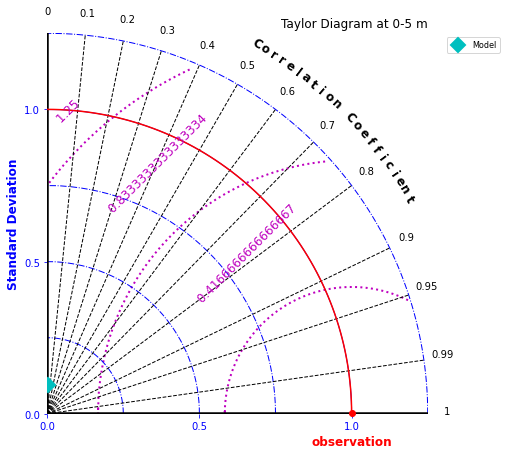

In [22]:
plot_Taylor(d_biomass_0_5,mo5_ma[0],plot_depth = '0-5')


Original Taylor stats:
SDEV pred: 17.11583, ref: 56.10948
CRMS pred: 58.56010, ref: 0.00000
CORRCOEF: 0.00622

Normalized Taylor stats:
SDEV pred: 0.30504, ref: 1.00000
CRMS pred: 1.04368, ref: 0.00000
CORRCOEF: 0.00622


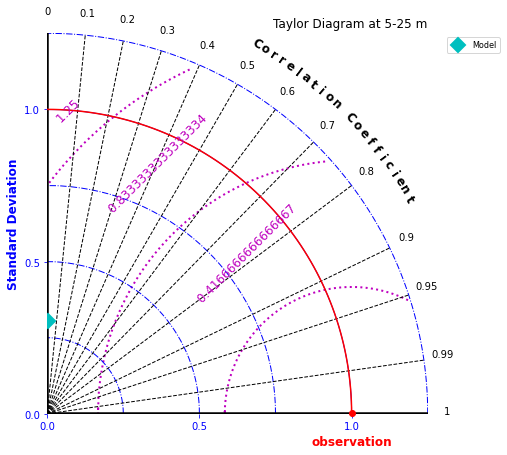

In [23]:
plot_Taylor(d_biomass_5_25,mo5_ma[1],plot_depth = '5-25')


Original Taylor stats:
SDEV pred: 8.17103, ref: 45.58821
CRMS pred: 45.70980, ref: 0.00000
CORRCOEF: 0.07472

Normalized Taylor stats:
SDEV pred: 0.17924, ref: 1.00000
CRMS pred: 1.00267, ref: 0.00000
CORRCOEF: 0.07472


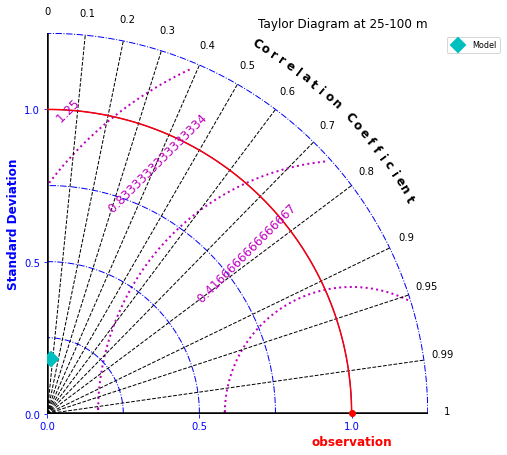

In [24]:
plot_Taylor(d_biomass_25_100,mo5_ma[2],plot_depth = '25-100')

# Scatter plots (as Miriam)

In [ ]:
### define function
def comp_scatter(model_masked,label,savefig = False):
    
    fig, axes = plt.subplots(4,2, #gridspec_kw={'hspace': 0.001, 'wspace': 0.1}, 
                             figsize=(10,10))

    m1 = axes[0,0]
    m1.plot(np.log10(model_masked[0]),np.log10(d_biomass_0_5),'.',color='black')
    m1.plot([-4,4], [-4,4])
    m1.set_xlim(-3,2.5)
    m1.set_ylim(-5,5)
    #plt.yticks([-5,-4,-3,-2,-1,0,1,2,3])
    m1.set_ylabel('Maredat Log$_{10}$ biomass \n [mg C m$^{-3}$]')
    m1.text(-2.5,4, "Depth range: 0-5 m",color='darkred')
    
    

    m1 = axes[0,1]
    m1.plot(np.log10(model_masked[0]),np.log10(d_biomass_0_5),'.',color='black')
    m1.plot([-4,4], [-4,4])
    m1.set_xlim(1,2)
    m1.set_ylim(-5,5)
    #plt.yticks([-5,-4,-3,-2,-1,0,1,2,3])
    #m1.set_ylabel('Maredat Log$_{10}$ biomass \n [mg C m$^{-3}$]')
    m1.text(1.1,4, "Depth range: 0-5 m",color='darkred')

    # ---------------------------------------------------------------------------------------------------

    m1 = axes[1,0]
    m1.plot(np.log10(model_masked[1]),np.log10(d_biomass_5_25),'.',color='black')
    m1.plot([-4,4], [-4,4])
    m1.set_xlim(-3,2.5)
    m1.set_ylim(-5,5)
    #plt.yticks([-5,-4,-3,-2,-1,0,1,2,3])
    m1.set_ylabel('Maredat Log$_{10}$ biomass \n [mg C m$^{-3}$]')
    m1.text(-2.5,4, "Depth range: 5-25 m",color='darkred')

    m1 = axes[1,1]
    m1.plot(np.log10(model_masked[1]),np.log10(d_biomass_5_25),'.',color='black')
    m1.plot([-4,4], [-4,4])
    m1.set_xlim(1,2)
    m1.set_ylim(-5,5)
    #plt.yticks([-5,-4,-3,-2,-1,0,1,2,3])
    #m1.set_ylabel('Maredat Log$_{10}$ biomass \n [mg C m$^{-3}$]')
    m1.text(1.4,4, "Depth range: 5-25 m",color='darkred')

    # ---------------------------------------------------------------------------------------------------

    m1 = axes[2,0]
    m1.plot(np.log10(model_masked[2]),np.log10(d_biomass_25_100),'.',color='black')
    m1.plot([-4,4], [-4,4])
    m1.set_xlim(-3,2.5)
    m1.set_ylim(-5,5)
    #plt.yticks([-5,-4,-3,-2,-1,0,1,2,3])
    m1.set_ylabel('Maredat Log$_{10}$ biomass \n [mg C m$^{-3}$]')
    m1.text(-2.5,4, "Depth range: 25-100 m",color='darkred')

    m1 = axes[2,1]
    m1.plot(np.log10(model_masked[2]),np.log10(d_biomass_25_100),'.',color='black')
    m1.plot([-4,4], [-4,4])
    m1.set_xlim(0,1.5)
    m1.set_ylim(-5,5)
    #plt.yticks([-5,-4,-3,-2,-1,0,1,2,3])
    #m1.set_ylabel('Maredat Log$_{10}$ biomass \n [mg C m$^{-3}$]')
    m1.text(0.2,4, "Depth range: 25-100 m",color='darkred')

    # ---------------------------------------------------------------------------------------------------

    m1 = axes[3,0]
    m1.plot(np.log10(model_masked[3]),np.log10(d_biomass_100_bot),'.',color='black')
    m1.plot([-4,4], [-4,4])
    m1.set_xlim(-3,2.5)
    m1.set_ylim(-5,5)
    #plt.yticks([-5,-4,-3,-2,-1,0,1,2,3])
    m1.set_ylabel('Maredat Log$_{10}$ biomass \n [mg C m$^{-3}$]')
    m1.set_xlabel('Model "'+label+'" Log$_{10}$ biomass \n [mg C m$^{-3}$]')
    m1.text(-2.5,4, "Depth range: 100 m - bottom",color='darkred')

    m1 = axes[3,1]
    m1.plot(np.log10(model_masked[3]),np.log10(d_biomass_100_bot),'.',color='black')
    m1.plot([-4,4], [-4,4])
    m1.set_xlim(-2,0.5)
    m1.set_ylim(-5,5)
    #plt.yticks([-5,-4,-3,-2,-1,0,1,2,3])
    #m1.set_ylabel('Maredat Log$_{10}$ biomass \n [mg C m$^{-3}$]')
    m1.set_xlabel('Model "'+label+'" Log$_{10}$ biomass \n [mg C m$^{-3}$]')
    m1.text(-1.5,4, "Depth range: 100 m - bottom",color='darkred')
    
    if(savefig == True):
        fig.savefig(savepath+'MarEDAT_scatter_'+label+'_'+str(years[0])+'to'+str(years[1])+'.png', 
                        dpi = 300, bbox_inches='tight')
    plt.show()

In [ ]:
comp_scatter(mo5_ma,'CONTROL_mo5',savefig=True)

In [ ]:
comp_scatter(mo6_ma,'mo6_Pcm_25',True)

In [ ]:
comp_scatter(mo7_ma,'mo6_Pcm_45',True)

In [ ]:
comp_scatter(mo4_ma,'CONTROL_woMask_mo4',savefig=True)

# Diatom silicate

Model depth: 0.0
Model depth: 0.0
Model depth: 0.0
Model depth: 0.0


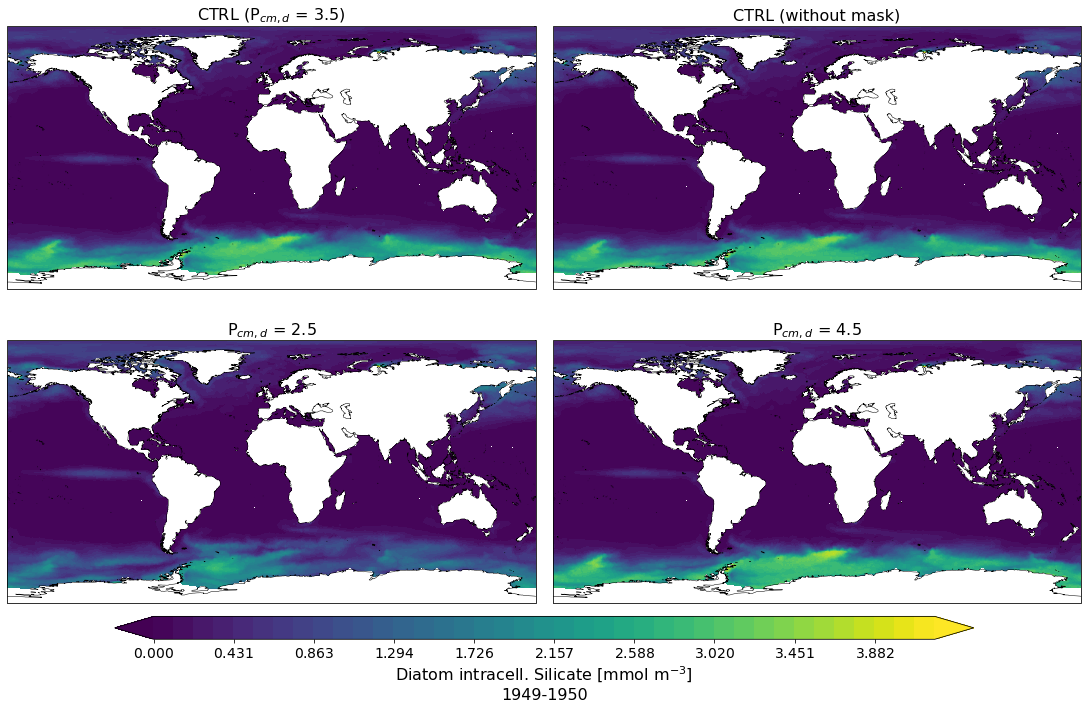

In [26]:
units = 'Diatom intracell. Silicate [mmol m$^{{-3}}$]\n{0}-{1}'.format(years[0],years[1])
#units = 'intracellular Si [mmol m$^{-3}$]'

DiaSi = [0]*len(idlist)

for i in range(len(idlist)):
    DiaSi[i] = pf.get_data(resultpath[i], "DiaSi", years, mesh, runid=idlist[i], how="mean", compute=True, depth=depth)

fig = pf.plot(mesh, [data for data in DiaSi], mapproj = mapproj, units=units, cmap = 'viridis',
              rowscol = rowscol, #(math.ceil(len(idlist)/3), 3), 
              figsize = (15,10),
              titles=[title for title in figlabel])

/home/ollie/mozeisin/.conda/envs/pyfesom2/lib/python3.8/site-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/ollie/mozeisin/.conda/envs/pyfesom2/lib/python3.8/site-packages/matplotlib/contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


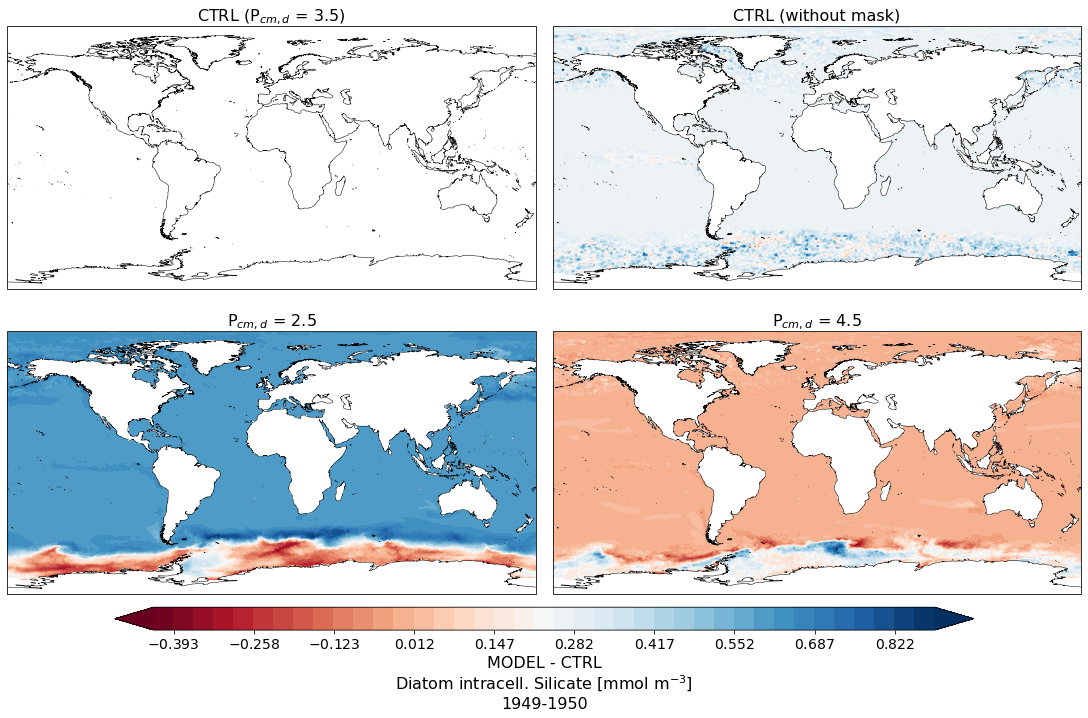

In [27]:
## differences
fig = pf.plot(mesh, [data-DiaSi[0] for data in DiaSi], mapproj = mapproj, units='MODEL - CTRL\n'+units, 
              rowscol = rowscol, #(math.ceil(len(idlist)/3), 3), 
              figsize = (15,10),
              #levels = (-2.5e-2,2.5e-2, 30), 
              cmap = 'RdBu',
              titles=[title for title in figlabel])

# Chl a

In [ ]:
# diatom chlorophyll
#!ncdump -h $NCfesom
depth = 0

DiaChl = [0]*len(idlist)

units ='Diatom Chl [mmol m$^{{-3}}$]\n{0}-{1} at {2} m'.format(years[0],years[1],depth)
#units = 'Chl.a [mmol m$^{-3}$]'

for i in range(len(idlist)):
    DiaChl[i] = pf.get_data(resultpath[i], "DiaChl", years, mesh, runid=idlist[i], how="mean", 
                            compute=True, depth=depth)

fig = pf.plot(mesh, [data for data in DiaChl], mapproj = mapproj, units=units, cmap = 'viridis',
              rowscol = rowscol, #(math.ceil(len(idlist)/3), 3), 
              figsize = (15,15),
              titles=[title for title in figlabel])

fig = pf.plot(mesh, [data-DiaChl[0] for data in DiaChl], mapproj = mapproj, units='MODEL - CTRL\n'+units, 
              rowscol = rowscol, #(math.ceil(len(idlist)/3), 3), 
              figsize = (15,15),
              #levels = (-2.5e-5,2.5e-5, 30), 
              cmap = 'RdBu',
              titles=[title for title in figlabel])

# Map of total Diatom NPP 

In [ ]:
#NCfesom = resultpath + '/NPPd.mo1.1948.nc'
#!ncdump -h $NCfesom

depth = 0

# 12.01* data --> mg C/m2/d

units ='Mean Diatom NPP [mg C m$^{{-2}}$ d$^{{-1}}$]\n{0}-{1} at {2} m'.format(years[0],years[1],depth)
#units = 'Mean NPP [mg C m$^{-2}$ d$^{-1}$]'

NPPd = [0]*len(idlist)

for i in range(len(idlist)):
    NPPd[i] = pf.get_data(resultpath[i], "NPPd", years, mesh, runid=idlist[i], how="mean", compute=True, depth=depth)
    NPPd[i] = NPPd[i] * 12.01

In [ ]:
fig = pf.plot(mesh, [data for data in NPPd], mapproj = mapproj, units=units, cmap = 'viridis',
              rowscol = rowscol, #(math.ceil(len(idlist)/3), 3), 
              figsize = (15,15),
              titles=[title for title in figlabel])

In [ ]:
## differences
fig = pf.plot(mesh, [data-NPPd[0] for data in NPPd], mapproj = mapproj, units='MODEL - CTRL\n'+units, 
              rowscol = rowscol, #(math.ceil(len(idlist)/3), 3), 
              figsize = (15,15),
              #levels = (-2.5e-2,2.5e-2, 30), 
              cmap = 'RdBu',
              titles=[title for title in figlabel])

# Map of nanophytoplankton NPP

In [ ]:
#NCfesom = resultpath + '/NPPn.mo1.1948.nc'
#!ncdump -h $NCfesom

# 12.01* data --> mg C/m2/d

units = 'Nanophytoplankton NPP [mg C m$^{{-2}}$ d$^{{-1}}$]\n{0}-{1} at {2} m'.format(years[0],years[1],depth)
#units = 'Mean NPP [mg C m$^{-2}$ d$^{-1}$]'

NPPn = [0]*len(idlist)

for i in range(len(idlist)):
    NPPn[i] = pf.get_data(resultpath[i], "NPPn", years, mesh, runid=idlist[i], how="mean", compute=True, depth=depth)
    NPPn[i] = NPPn[i] * 12.01

In [ ]:
fig = pf.plot(mesh, [data for data in NPPn], mapproj = mapproj, units=units, cmap = 'viridis',
              rowscol = rowscol, #(math.ceil(len(idlist)/3), 3), 
              figsize = (15,15),
              titles=[title for title in figlabel])

In [ ]:
## differences
fig = pf.plot(mesh, [data-NPPn[0] for data in NPPn], mapproj = mapproj, units='MODEL - CTRL\n'+units, 
              rowscol = rowscol, #(math.ceil(len(idlist)/3), 3), 
              figsize = (15,15),
              #levels = (-30,30, 30), 
              cmap = 'RdBu',
              titles=[title for title in figlabel])

# Total NPP

In [ ]:
units ='Total Net Primary Production [mg C m$^{{-2}}$ d$^{{-1}}$]\n{0}-{1}  at {2} m'.format(years[0],years[1],depth)
#units = 'Mean total NPP [mg C m$^{-2}$ d$^{-1}$]'

NPPtot = [NPPd[i] + NPPn[i] for i in range(len(idlist))]

In [ ]:
fig = pf.plot(mesh, [data for data in NPPtot], mapproj = mapproj, units=units, cmap = 'viridis',
              rowscol = rowscol, #(math.ceil(len(idlist)/3), 3), 
              figsize = (15,15),
              titles=[title for title in figlabel])

In [ ]:
## differences
fig = pf.plot(mesh, [data-NPPtot[0] for data in NPPtot], mapproj = mapproj, units='MODEL - CTRL\n'+units, 
              rowscol = rowscol, #(math.ceil(len(idlist)/3), 3), 
              figsize = (15,15),
              #levels = (-2.5e-1,2.5e-1, 30), 
              cmap = 'RdBu',
              titles=[title for title in figlabel])

# Nutrients

In [ ]:
from DIN_WOA_Comparison_python3 import DINcomp

In [ ]:
# check DIN comp to WOA FOR CONTROL RUN

#ctrl = DINcomp('fesom',resultpath[0],savepath,meshpath,ncfileDIN,first_year,last_year,mapproj=mapproj)

In [ ]:
# run DINcomp for each result
if False:
    for i in range(len(resultpath)):
        print('\n****************************** \nANALYSING {0} \n******************************'.format(resultpath[i]))
        fig = DINcomp(idlist[i],resultpath[i],savepath,meshpath,ncfileDIN,first_year,last_year,mapproj=mapproj)

In [ ]:
stop

## Data

In [ ]:
#pf.get_data?

In [ ]:
years = range(1948,1951)
runid = 'mo1'

datapath = resultpath + runid

#var = 'temp'
var = 'DiaChl'

In [ ]:
%%bash 
ncdump -h /work/ollie/mozeisin/results/f2r1.2/mo1/DiaChl.mo1.1950.nc 

In [ ]:
data = pf.get_data(datapath,
                   var, 
                   years,
                   mesh,
                   runid=runid,
                   how='ori',
                   compute=False) #,chunks={'nod2':10000, 'nz1':5})

In [ ]:
data.shape

In [ ]:
data_mean = data.mean(dim='time').compute()
data_mean.shape
              

## Plotting

In [ ]:
pf.plot(mesh, data_mean[:,0].values, units=var)

In [ ]:
pf.plot(mesh, data_mean[:,0].values, mapproj='np', box=[-180, 180, 60, 90], units=var)

#### Regional mask

In [ ]:
#np.ma.masked_array?

In [ ]:
#pf.get_mask?

In [ ]:
mask_al = np.invert(pf.get_mask(mesh, "Atlantic_Basin"))
#mask_al.shape

In [ ]:
pf.plot(mesh, 
        np.ma.masked_array(data_mean[:,0].values, mask=mask_al), 
        units=var,
        box = [-100,30,-50,80])

In [ ]:
mesh.n2d

## Differences

In [ ]:
years = range(1949,1951)
var = 'DiaChl'

runid = 'mo1'
data_mean_mo1 = pf.get_data(resultpath + runid,
                   var, 
                   years,
                   mesh,
                   runid=runid,
                   how='mean',
                   compute=True) 

runid = 'mo2'
data_mean_mo2 = pf.get_data(resultpath + runid,
                   var, 
                   years,
                   mesh,
                   runid=runid,
                   how='mean',
                   compute=True)

runid = 'mo3'
data_mean_mo3 = pf.get_data(resultpath + runid,
                   var, 
                   years,
                   mesh,
                   runid=runid,
                   how='mean',
                   compute=True)

In [ ]:
#pf.plot?

In [ ]:
pf.plot(mesh, 
        [data_mean_mo1[:,0], data_mean_mo2[:,0], data_mean_mo3[:,0]], 
        units = var,
       rowscol=[3,1],
        titles=['mo1', 'mo2', 'mo3'],
       figsize=(14,10))


#### Differences

In [ ]:
pf.plot(mesh, 
        [data_mean_mo1[:,0]- data_mean_mo2[:,0], data_mean_mo1[:,0]- data_mean_mo3[:,0]],
        units = var + ' (Ctrl - test)',
        cmap=cm.seismic,
        levels = (-2e-5, 6e-5,30),
        titles = ['Differences ' + var + ' $\longrightarrow$ P$_{cm,d}$ = 2.5',
                 'Differences ' + var + ' $\longrightarrow$ P$_{cm,d}$ = 4.5'],
        rowscol = [1,2],
       figsize=(14,10))

In [ ]:
pf.plot(mesh, 
        [data_mean_mo1[:,0]- data_mean_mo2[:,0]],
        units = var,
        cmap=cm.seismic,
        levels = (-2e-5, 6e-5,30),
        titles = 'Differences ' + var + ' $\longrightarrow$ P$_{cm,d}$ = 2.5',
       figsize=(12,10))

In [ ]:
pf.plot(mesh, 
        [data_mean_mo1[:,0]- data_mean_mo3[:,0]],
        units = var,
        cmap=cm.seismic,
        levels = (-2e-5, 6e-5,30),
        titles = 'Differences ' + var + ' $\longrightarrow$ P$_{cm,d}$ = 4.5',
       figsize=(12,10))

## Transect

#### Atlantic :  Diatom Chl

In [ ]:
lon_start = -25
lat_start = -50
lon_end = -25
lat_end = 65
npoints   = 50
lonlat = pf.transect_get_lonlat(lon_start, lat_start, lon_end, lat_end, npoints)

pf.plot_transect_map(lonlat, mesh)

In [ ]:
dist, transect_data = pf.get_transect(data_mean_mo1,mesh,lonlat)
dist2, transect_data2 = pf.get_transect(data_mean_mo2,mesh,lonlat)
dist3, transect_data3 = pf.get_transect(data_mean_mo3,mesh,lonlat)

pf.plot_xyz(mesh, 
            [transect_data,transect_data2,transect_data3],
            dist,
            maxdepth=500,
            ncols=3,
            xlabel='Distance',
            label='Diatom Chl',
            title=['Transect Dia Chl CTRL', 'Transect Dia Chl $\longrightarrow$ P$_{cm,d}$ = 2.5',
                 'Transect Dia Chl $\longrightarrow$ P$_{cm,d}$ = 4.5'],
            #levels=np.linspace(-2,2, 41),cmap=cm.hot_r,
            figsize=(15, 6))
print('Atlantic Transect, mean 1949-1950')

In [ ]:
#pf.plot_xyz?

#### Fram Strait: Temperature

In [ ]:
year = 1950

In [ ]:
temp = pf.get_data(resultpath + runid, 'temp', year, mesh, runid=runid)

In [ ]:
lon_start = -5
lat_start = 85
lon_end = -5
lat_end = 75
npoints   = 50
lonlat = pf.transect_get_lonlat(lon_start, lat_start, lon_end, lat_end, npoints)

In [ ]:
pf.plot_transect_map(lonlat, mesh, view='np')

In [ ]:
dist, temp_transect_data = pf.get_transect(temp,
    mesh,
    lonlat)
pf.plot_xyz(mesh, temp_transect_data, dist)

In [ ]:
pf.plot_xyz(mesh, 
            temp_transect_data,
            dist,
            maxdepth=2000,
            label="deg C",
            title="Transect",
            levels=np.linspace(-2,2, 41),
            cmap=cm.hot_r
           )

## Plotting NPPd

In [ ]:
%%bash
ncdump -h /work/ollie/mozeisin/results/f2r1.2/mo1/NPPd.mo1.1950.nc 

In [ ]:
var = 'NPPd'
years = range(1949,1951)
runid = 'mo1'

data_NPPd = pf.get_data(datapath,
                   var, 
                   years,
                   mesh,
                   runid=runid,
                   how='mean',
                   compute=True)
                
#data_NPPd_mean = data_NPPd.mean(dim='time').compute()  
np.shape(data_NPPd)

In [ ]:
pf.plot(mesh, data_NPPd, 
        #mapproj='np', 
        #box=[-180, 180, 60, 90], 
        units='mean NPPd [mmolC/(m3*d)]')

#### Differences

In [ ]:
runid = 'mo1'
data_mean_mo1 = pf.get_data(resultpath + runid,
                   var, 
                   years,
                   mesh,
                   runid=runid,
                   how='mean',
                   compute=True) 

runid = 'mo2'
data_mean_mo2 = pf.get_data(resultpath + runid,
                   var, 
                   years,
                   mesh,
                   runid=runid,
                   how='mean',
                   compute=True)

runid = 'mo3'
data_mean_mo3 = pf.get_data(resultpath + runid,
                   var, 
                   years,
                   mesh,
                   runid=runid,
                   how='mean',
                   compute=True)

pf.plot(mesh, 
        [data_mean_mo1, data_mean_mo1,
         data_mean_mo2, data_mean_mo1 - data_mean_mo2,
         data_mean_mo3, data_mean_mo1 - data_mean_mo3], 
        units = var,
       rowscol=[3,2],
        titles=['mo1 $\longrightarrow$ P$_{cm,d}$ = 3.5', 'mo1', 
                'mo2 $\longrightarrow$ P$_{cm,d}$ = 2.5', 'mo1-mo2', 
                'mo3 $\longrightarrow$ P$_{cm,d}$ = 4.5', 'mo1-mo3'],
       figsize=(14,10))

## Evaluation

#### MareDat from Miriam

In [ ]:
data_file1 = 'MarEDat20120716Diatoms.nc' 
datamacro  = '/work/ollie/mseifert/'+data_file1
ncfile     = datamacro

In [ ]:
%%bash
ncdump -h /work/ollie/mseifert/MarEDat20120716Diatoms.nc
# BIOMASS:units = "ug/L"

In [ ]:
f          = Dataset(ncfile, 'r')
biomass_macro  = f['BIOMASS'][:]
lon_macro      = f['LONGITUDE'][:]
lat_macro      = f['LATITUDE'][:]
depth_macro    = f['DEPTH'][:]

biomass_macro[:][biomass_macro[:] == 1e+35] = np.nan
biomass_macro_an = np.nanmean(biomass_macro[:],axis=0)
biomass_macro_an_int = np.nansum(biomass_macro_an[:],axis=0)

dep_ind   = np.nonzero((0 <= depth_macro[:] )&(depth_macro[:] <= 5))
dep_ind2  = np.nonzero((5 < depth_macro[:] )&(depth_macro[:] <= 25))
dep_ind3  = np.nonzero((25 < depth_macro[:] )&(depth_macro[:] <= 100))
dep_ind4  = np.nonzero((100 < depth_macro[:]))

macro_so        = biomass_macro_an
macro_so_050    = np.squeeze(np.nansum(macro_so[dep_ind],axis=0))         #squeeze: To get rid of the depth dimension (180, 360 instead of 1, 180, 360)                                                         
macro_so_50150  = np.squeeze(np.nansum(macro_so[dep_ind2],axis=0))
macro_so_150350 = np.squeeze(np.nansum(macro_so[dep_ind3],axis=0))
macro_so_350    = np.squeeze(np.nansum(macro_so[dep_ind4],axis=0))

In [ ]:
np.shape(macro_so_050)


In [ ]:
plt.pcolor(macro_so_050)
plt.colorbar()

#### Comparision with Bracher et al. (2019) PS106

In [ ]:
# import from PANGAEA
ds= pd.PanDataSet(899284)
print(ds.title)
PS106.head()
# Chl a in µg/L

PS106 = ds.data

#print(np.shape(PS106), type(PS106))

fig_PS106 = PS106.plot(kind='scatter', 
           x='Longitude', y='Latitude',
          c='Chl a diatoms', cmap=plt.get_cmap("jet"), colorbar=True,
          figsize = (10,7))

In [ ]:
# plot with cartopy

# defining projections
og = ccrs.Orthographic(0,90)
pc = ccrs.PlateCarree()

PS106_Chla_dia = PS106['Chl a diatoms']
lat, lon = PS106['Latitude'], PS106['Longitude']

fig = plt.figure(figsize=(20, 16))
ax = plt.axes(projection=og)
ax.coastlines()
ax.gridlines()
plt.scatter(lon, lat, transform = pc, 
    c=PS106_Chla_dia, cmap=plt.get_cmap("jet"))
ax.set_extent([-20, 50, 60, 90])
ax.stock_img()
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('PS106 Diatom Chlorophyll a  (Bracher et al., 2019)')
plt.colorbar(label='Diatom Chl.a [µg/L]')
#plt.clim(0, 10)

## Evaluation scripts from pyfesom 2

#### Diatom Chla integrals

In [ ]:
DiaChl = pf.get_data(datapath, 'DiaChl', years, mesh, runid=runid, how=None, compute=False)

In [ ]:
#pf.volmean_data?
DiaChl_volmean = pf.volmean_data(DiaChl, mesh, meshdiag=datapath + "mo1  .mesh.diag.nc", runid = runid)

In [ ]:
DiaChl_volmean.plot()

#### Sea Ice integrals

In [ ]:
a_ice = pf.get_data(datapath, 'a_ice', range(1948,1951), mesh, runid='mo1', how=None, compute=False)

ice_area = pf.ice_area(a_ice, mesh,)
ice_ext = pf.ice_ext(a_ice, mesh)

ice_area.plot()

# Export to HTML

In [ ]:
%autosave 2

time.sleep(15)

!jupyter nbconvert MZ_F2R_sensitivity_runs_python3.ipynb --output-dir=$htmlpath --output $htmlname --to html 

# OLD STUFF

In [ ]:
### get interpolation input -> data of all levels
if False:
    # annual mean of fesom data already caluclated when reading model results
    i=0
    DiaC_interp_in = pf.get_data(resultpath[i], "DiaC", years, mesh, runid=idlist[i], how="mean")
    DiaC_interp_in = DiaC_interp_in * 12.01
    print(np.shape(DiaC_interp_in))

    # interp preperation
    lons, lats = np.meshgrid(lon_maredat, lat_maredat)

    # depth indices similar to MarEDAT
    depth_range = [0,5,25,100,1e5]
    dep_ind1  = np.nonzero((0 >= mesh_depths )&(mesh_depths >= -5))
    dep_ind2  = np.nonzero((-5 > mesh_depths )&(mesh_depths >= -25))
    dep_ind3  = np.nonzero((-25 > mesh_depths )&(mesh_depths >= -100))
    dep_ind4  = np.nonzero((-100 > mesh_depths))

    dep_ind = [dep_ind1,dep_ind2,dep_ind3,dep_ind4]

    #print(dep_ind1, dep_ind4)

    # storage
    DiaC_interp_all = [0]*len(idlist)

    for d in range(len(dep_ind)):
        d1 = depth_range[d]
        d2 = depth_range[d+1]
        dep_i = dep_ind[d]
        print('\nProcessing {4}\nDepth range {0}-{1} m for years {2}-{3}'.format(d1,d2,years[0],years[1],resultpath[i]))

        DiaC_interp_dep = np.squeeze(DiaC_interp_in[:,dep_ind1])
        #print(np.shape(DiaC_interp_dep))

        # interpolate fesom data to 1x1 grid
        DiaC_interp = pf.fesom2regular(
                data = DiaC_interp_dep,
                mesh = mesh,
                lons = lons, 
                lats = lats)

        #print(np.shape(DiaC_interp))

        # save to storage
        DiaC_interp_all[i] = DiaC_interp


In [25]:
#### manually calculating and plotting Taylor statistics
if False:
    # get indices for valid data points 
    ind_stat = np.where(mo5_ma[2] != 0)

    taylor_stats1 = sm.taylor_statistics(mo5_ma[2][ind_stat],d_biomass_25_100[ind_stat])
    print(taylor_stats1)

    sdev = np.array([taylor_stats1['sdev'][0]/taylor_stats1['sdev'][0], 
                     taylor_stats1['sdev'][1]/taylor_stats1['sdev'][0]])

    crmsd = np.array([taylor_stats1['crmsd'][0]/taylor_stats1['sdev'][0],
                      taylor_stats1['crmsd'][1]/taylor_stats1['sdev'][0]])

    ccoef = np.array([taylor_stats1['ccoef'][0], 
                      taylor_stats1['ccoef'][1]])

    print('\nNormalized Taylor stats:\nSDEV pred: {0:6.5f}, ref: {1:6.5f}\nCRMS pred: {2:6.5f}, ref: {3:6.5f}\nCORRCOEF: {4:6.5f}'.format(
                sdev[1],sdev[0],crmsd[1],crmsd[0],ccoef[1], ccoef[0]))

    fig = plt.figure(figsize=(7,7), facecolor='w', edgecolor='k')
    sm.taylor_diagram(sdev,crmsd,ccoef, styleOBS = '-', colOBS = 'r', markerobs = 'o',
                          titleOBS = 'observation', markerLabel = ['obs','model'],
                          markerLabelColor = 'c',
                          markerColor = 'c', markerLegend = 'on',
                          markerSize = 12,
                          #tickRMS = range(0,5,1),
                          #tickRMSangle = tickRMSangle,
                          colRMS = 'm', styleRMS = ':', #widthRMS = 2.0,
                          titleRMS = 'off', #tickSTD = np.arange(0,1.25,.25),
                          #axismax = 1.25, 
                          colSTD = 'b', styleSTD = '-.',
                          widthSTD = 1.0, titleSTD = 'on',
                          colCOR = 'k', styleCOR = '--', widthCOR = 1.0,
                          titleCOR = 'on')

In [ ]:
### old scatter plot, manually
if False:
    fig, axes = plt.subplots(4,2, #gridspec_kw={'hspace': 0.001, 'wspace': 0.1}, 
                             figsize=(10,10))

    m1 = axes[0,0]
    m1.plot(np.log10(mo5_ma[0]),np.log10(d_biomass_0_5),'.',color='black')
    m1.plot([-4,4], [-4,4])
    m1.set_xlim(-3,2.5)
    m1.set_ylim(-5,5)
    #plt.yticks([-5,-4,-3,-2,-1,0,1,2,3])
    m1.set_ylabel('Maredat Log$_{10}$ biomass \n [mg C m$^{-3}$]')
    m1.text(-2.5,4, "Depth range: 0-5 m",color='darkred')

    m1 = axes[0,1]
    m1.plot(np.log10(mo5_ma[0]),np.log10(d_biomass_0_5),'.',color='black')
    m1.plot([-4,4], [-4,4])
    m1.set_xlim(1,2)
    m1.set_ylim(-5,5)
    #plt.yticks([-5,-4,-3,-2,-1,0,1,2,3])
    #m1.set_ylabel('Maredat Log$_{10}$ biomass \n [mg C m$^{-3}$]')
    m1.text(1.1,4, "Depth range: 0-5 m",color='darkred')

    # ---------------------------------------------------------------------------------------------------

    m1 = axes[1,0]
    m1.plot(np.log10(mo5_ma[1]),np.log10(d_biomass_5_25),'.',color='black')
    m1.plot([-4,4], [-4,4])
    m1.set_xlim(-3,2.5)
    m1.set_ylim(-5,5)
    #plt.yticks([-5,-4,-3,-2,-1,0,1,2,3])
    m1.set_ylabel('Maredat Log$_{10}$ biomass \n [mg C m$^{-3}$]')
    m1.text(-2.5,4, "Depth range: 5-25 m",color='darkred')

    m1 = axes[1,1]
    m1.plot(np.log10(mo5_ma[1]),np.log10(d_biomass_5_25),'.',color='black')
    m1.plot([-4,4], [-4,4])
    m1.set_xlim(1,2)
    m1.set_ylim(-5,5)
    #plt.yticks([-5,-4,-3,-2,-1,0,1,2,3])
    #m1.set_ylabel('Maredat Log$_{10}$ biomass \n [mg C m$^{-3}$]')
    m1.text(1.4,4, "Depth range: 5-25 m",color='darkred')

    # ---------------------------------------------------------------------------------------------------

    m1 = axes[2,0]
    m1.plot(np.log10(mo5_ma[2]),np.log10(d_biomass_25_100),'.',color='black')
    m1.plot([-4,4], [-4,4])
    m1.set_xlim(-3,2.5)
    m1.set_ylim(-5,5)
    #plt.yticks([-5,-4,-3,-2,-1,0,1,2,3])
    m1.set_ylabel('Maredat Log$_{10}$ biomass \n [mg C m$^{-3}$]')
    m1.text(-2.5,4, "Depth range: 25-100 m",color='darkred')

    m1 = axes[2,1]
    m1.plot(np.log10(mo5_ma[2]),np.log10(d_biomass_25_100),'.',color='black')
    m1.plot([-4,4], [-4,4])
    m1.set_xlim(0,1.5)
    m1.set_ylim(-5,5)
    #plt.yticks([-5,-4,-3,-2,-1,0,1,2,3])
    #m1.set_ylabel('Maredat Log$_{10}$ biomass \n [mg C m$^{-3}$]')
    m1.text(0.2,4, "Depth range: 25-100 m",color='darkred')

    # ---------------------------------------------------------------------------------------------------

    m1 = axes[3,0]
    m1.plot(np.log10(mo5_ma[3]),np.log10(d_biomass_100_bot),'.',color='black')
    m1.plot([-4,4], [-4,4])
    m1.set_xlim(-3,2.5)
    m1.set_ylim(-5,5)
    #plt.yticks([-5,-4,-3,-2,-1,0,1,2,3])
    m1.set_ylabel('Maredat Log$_{10}$ biomass \n [mg C m$^{-3}$]')
    m1.set_xlabel('Model "mo5" Log$_{10}$ biomass \n [mg C m$^{-3}$]')
    m1.text(-2.5,4, "Depth range: 100 m - bottom",color='darkred')

    m1 = axes[3,1]
    m1.plot(np.log10(mo5_ma[3]),np.log10(d_biomass_100_bot),'.',color='black')
    m1.plot([-4,4], [-4,4])
    m1.set_xlim(-2,0.5)
    m1.set_ylim(-5,5)
    #plt.yticks([-5,-4,-3,-2,-1,0,1,2,3])
    #m1.set_ylabel('Maredat Log$_{10}$ biomass \n [mg C m$^{-3}$]')
    m1.set_xlabel('Model "mo5" Log$_{10}$ biomass \n [mg C m$^{-3}$]')
    m1.text(-1.5,4, "Depth range: 100 m - bottom",color='darkred')

    fig.savefig(savepath)

In [ ]:
if False:
    ### plot FESOM overview
    fig, axes = plt.subplots(2,2, 
                             subplot_kw=dict(projection=ccrs.Robinson()),
                             gridspec_kw={'hspace': 0.001, 'wspace': 0.1},
                             figsize=(20,15))
    fig.tight_layout()

    # 0-5 m
    m1 = axes[0,0]
    f1 = m1.pcolormesh(lon_maredat, lat_maredat, np.log10(mo5[0]), 
                       transform = ccrs.PlateCarree(),
                        shading='flat', vmin=np.log10(0.001), vmax=np.log10(200), 
                        cmap=plt.cm.viridis)
    mygrid(m1)
    m1.set_title('FESOM 0-5 m', fontsize=20)


    # 5-25 m
    m2 = axes[0,1]
    f2 = m2.pcolormesh(lon_maredat, lat_maredat, np.log10(mo5[1]), 
                       transform = ccrs.PlateCarree(),
                        shading='flat', vmin=np.log10(0.001), vmax=np.log10(200), 
                        cmap=plt.cm.viridis)
    mygrid(m2)
    m2.set_title('FESOM 5-25 m', fontsize=20)

    # 25-100 m
    m3 = axes[1,0]
    f3 = m3.pcolormesh(lon_maredat, lat_maredat, np.log10(mo5[2]), 
                       transform = ccrs.PlateCarree(),
                        shading='flat', vmin=np.log10(0.001), vmax=np.log10(200), 
                        cmap=plt.cm.viridis)
    mygrid(m3)
    m3.set_title('FESOM 25-100 m', fontsize=20)

    # 100-bottom m
    m4 = axes[1,1]
    f4 = m4.pcolormesh(lon_maredat, lat_maredat, np.log10(mo5[3]), 
                       transform = ccrs.PlateCarree(),
                        shading='flat', vmin=np.log10(0.001), vmax=np.log10(200), 
                        cmap=plt.cm.viridis)
    mygrid(m4)
    m4.set_title('FESOM 100 m - bottom', fontsize=20)

    # add one colorbar for all plots below figure
    cbar = fig.colorbar(f1,
                        ax = axes[1,:2], 
                        location ='bottom',
                        ticks=[np.log10(0.001),np.log10(0.01), np.log10(0.1),np.log10(0.5), np.log10(1),np.log10(10),np.log10(50),np.log10(100),np.log10(200)],
                        fraction=0.1, pad=0.1) 
    cbar.ax.set_xticklabels(['0.001','0.01','0.1','0.5','1','10','50','100','200'], fontsize=20) 
    cbar.set_label('Run "mo5", Diatom Biomass [mg C m$^{-3}$]', fontsize=20)
    #cbar.set_label('Log$_{10}$ Biomass [$\mu$g L $^{-1}$]', fontsize=20)



In [ ]:
### maredat fesom side by side
if False:
    fig, axes = plt.subplots(4,2, 
                             subplot_kw=dict(projection=ccrs.Robinson()),
                             gridspec_kw={'hspace': 0.001, 'wspace': 0.1},
                             figsize=(30,45))
    fig.tight_layout()

    # 0-5 m maredat ---------------------------------------------------------------------------------------------
    m1 = axes[0,0]
    f1 = m1.pcolormesh(lon_maredat, lat_maredat, np.log10(d_biomass_0_5), 
                       transform = ccrs.PlateCarree(),
                        shading='flat', vmin=np.log10(0.001), vmax=np.log10(200), 
                        cmap=plt.cm.viridis)
    mygrid(m1)
    m1.set_title('MarEDAT 0-5 m', fontsize=20)

    # 0-5 m FESOM
    m1 = axes[0,1]
    f1 = m1.pcolormesh(lon_maredat, lat_maredat, np.log10(mo5[0]), 
                       transform = ccrs.PlateCarree(),
                        shading='flat', vmin=np.log10(0.001), vmax=np.log10(200), 
                        cmap=plt.cm.viridis)
    mygrid(m1)
    m1.set_title('FESOM 0-5 m', fontsize=20)

    # 5-25 m maredat ---------------------------------------------------------------------------------------------
    m2 = axes[1,0]
    f2 = m2.pcolormesh(lon_maredat, lat_maredat, np.log10(d_biomass_5_25), 
                       transform = ccrs.PlateCarree(),
                        shading='flat', vmin=np.log10(0.001), vmax=np.log10(200), 
                        cmap=plt.cm.viridis)
    mygrid(m2)
    m2.set_title('MarEDAT 5-25 m', fontsize=20)

    # 5-25 m FESOM
    m2 = axes[1,1]
    f2 = m2.pcolormesh(lon_maredat, lat_maredat, np.log10(mo5[1]), 
                       transform = ccrs.PlateCarree(),
                        shading='flat', vmin=np.log10(0.001), vmax=np.log10(200), 
                        cmap=plt.cm.viridis)
    mygrid(m2)
    m2.set_title('FESOM 5-25 m', fontsize=20)

    # 25-100 m maredat ---------------------------------------------------------------------------------------------
    m3 = axes[2,0]
    f3 = m3.pcolormesh(lon_maredat, lat_maredat, np.log10(d_biomass_25_100), 
                       transform = ccrs.PlateCarree(),
                        shading='flat', vmin=np.log10(0.001), vmax=np.log10(200), 
                        cmap=plt.cm.viridis)
    mygrid(m3)
    m3.set_title('MarEDAT 25-100 m', fontsize=20)

    # 25-100 m FESOM
    m3 = axes[2,1]
    f3 = m3.pcolormesh(lon_maredat, lat_maredat, np.log10(mo5[2]), 
                       transform = ccrs.PlateCarree(),
                        shading='flat', vmin=np.log10(0.001), vmax=np.log10(200), 
                        cmap=plt.cm.viridis)
    mygrid(m3)
    m3.set_title('FESOM 25-100 m', fontsize=20)

    # 100-bottom m maredat ---------------------------------------------------------------------------------------------
    m4 = axes[3,0]
    f4 = m4.pcolormesh(lon_maredat, lat_maredat, np.log10(d_biomass_100_bot), 
                       transform = ccrs.PlateCarree(),
                        shading='flat', vmin=np.log10(0.001), vmax=np.log10(200), 
                        cmap=plt.cm.viridis)
    mygrid(m4)
    m4.set_title('MarEDAT 100 m - bottom', fontsize=20)

    # 100-bottom m
    m4 = axes[3,1]
    f4 = m4.pcolormesh(lon_maredat, lat_maredat, np.log10(mo5[3]), 
                       transform = ccrs.PlateCarree(),
                        shading='flat', vmin=np.log10(0.001), vmax=np.log10(200), 
                        cmap=plt.cm.viridis)
    mygrid(m4)
    m4.set_title('FESOM 100 m - bottom', fontsize=20)

    # ---------------------------------------------------------------------------------------------
    # add one colorbar for all plots below figure
    cbar = fig.colorbar(f1,
                        ax = axes[3,:2], 
                        location ='bottom',
                        ticks=[np.log10(0.001),np.log10(0.01), np.log10(0.1),np.log10(0.5), np.log10(1),np.log10(10),np.log10(50),np.log10(100)],
                        fraction=0.1, pad=0.1) 
    cbar.ax.set_xticklabels(['0.001','0.01','0.1','0.5','1','10','50','100'], fontsize=20) 
    cbar.set_label('Diatom Biomass [mg C m$^{-3}$]', fontsize=20)
    #cbar.set_label('Log$_{10}$ Biomass [$\mu$g L $^{-1}$]', fontsize=20)

